In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from datetime import datetime
import xgboost as xgb
import random
from sklearn.model_selection import cross_val_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
TRAIN_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '/kaggle/input/real-estate-price-prediction-moscow/test.csv'

In [6]:
train_data = pd.read_csv(TRAIN_DATASET_PATH)
test_data = pd.read_csv(TEST_DATASET_PATH)

In [7]:
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [8]:
train_data = train_data.drop('Id', 1)

In [9]:
#посмотрим на типы данных до преобразования
train_data.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [10]:
# уменьшение занимаемого объема памяти
def reduce_mem_usage(train_data):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type != object:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')

    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return train_data

In [11]:
train_data = reduce_mem_usage(train_data)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.47 MB
Decreased by 67.7%


In [12]:
#посмотрим на типы данных после преобразования
train_data.dtypes

DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [13]:
#посомтрим на основные статистики по признакам
train_data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


Вывод:
- выбросы в признаках Rooms, Square, LifeSquare, KitchenSquare, HouseYear, Social_2, Social_3, Healthcare_1
- пропуски в признаках LifeSquare, Healthcare_1

## Целевая переменная

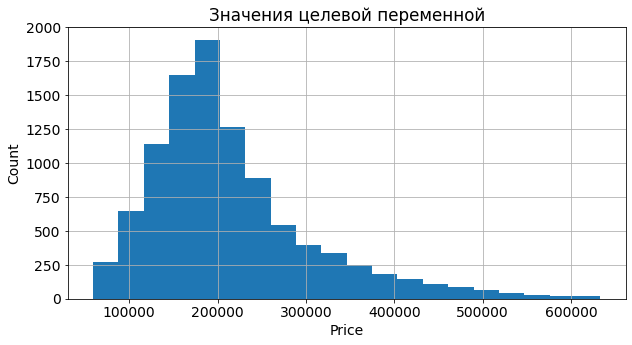

In [14]:
plt.figure(figsize = (10, 5))

train_data['Price'].hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Значения целевой переменной')
plt.show()

## Признаки

array([[<AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>],
       [<AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>],
       [<AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>],
       [<AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>,
        <AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Price'}>]], dtype=object)

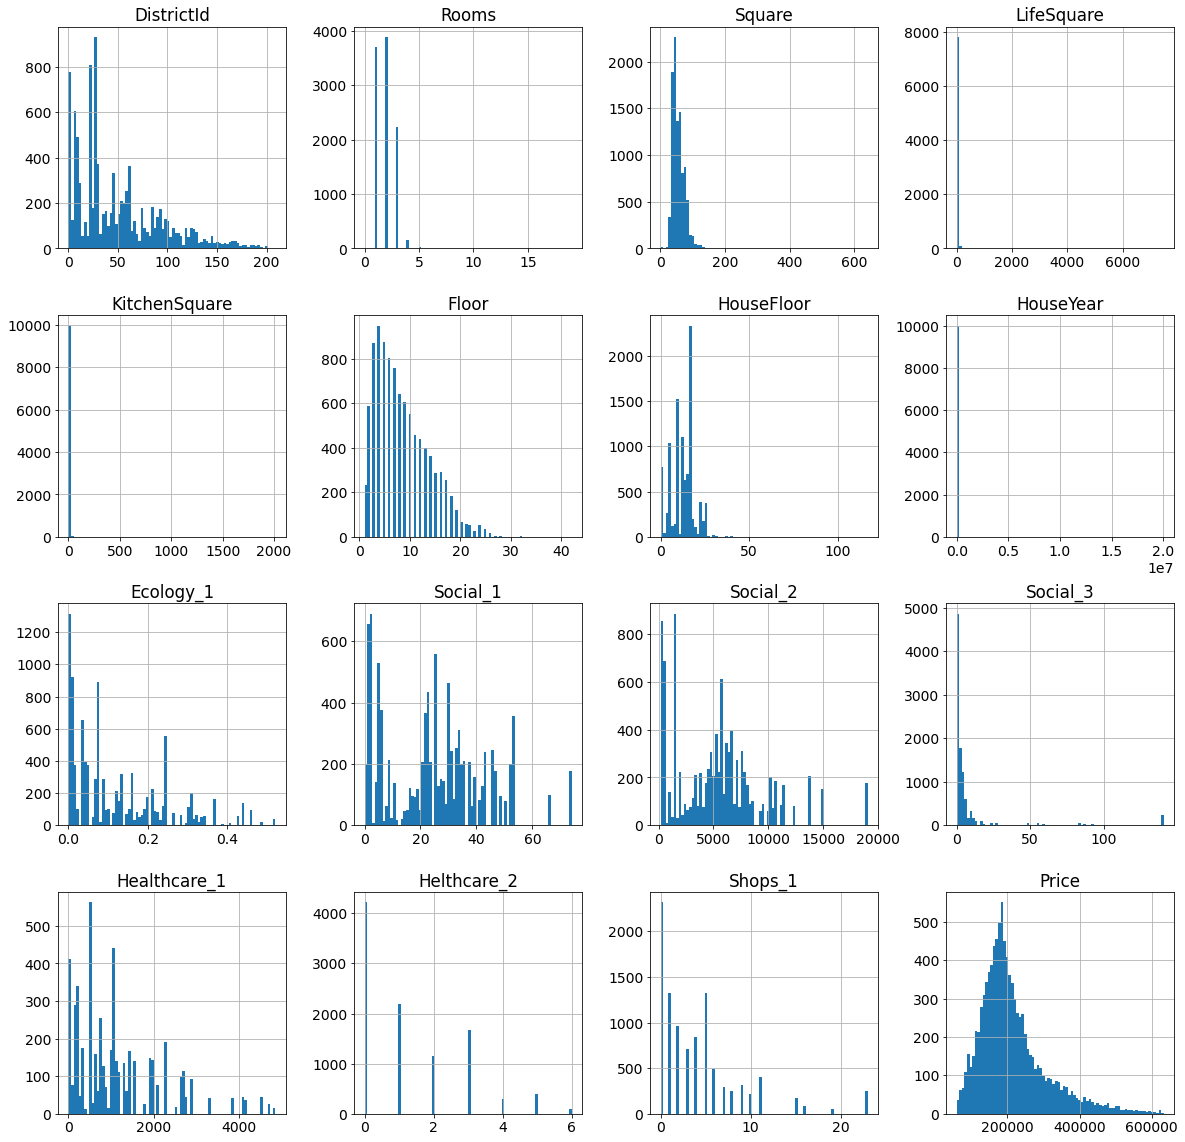

In [15]:
train_data.hist(bins=80, figsize=(20,20))

## 1. Обработка выбросов

### 1.1 Признак Rooms

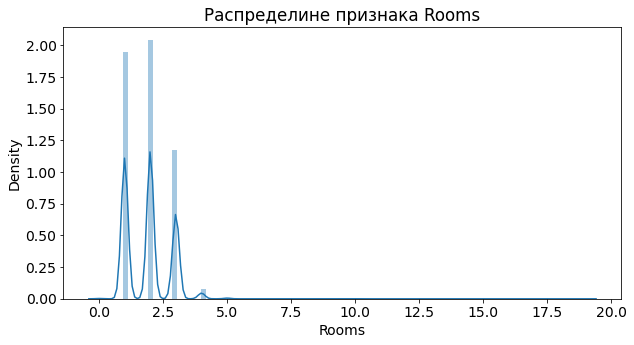

In [16]:
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Rooms'], bins=100)
plt.title('Распределине признака Rooms')
plt.show()

In [17]:
#Посмотрим какие значения принимает признак Rooms 
train_data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

In [18]:
#Посмотрим на квартиры с количеством комнат >= 6 и < 1:
train_data[(train_data['Rooms'] >= 6) | (train_data['Rooms'] == 0)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500
2194,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375
2728,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.265625
3780,27,0.0,41.790882,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976562
5894,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750
6088,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188
6401,27,0.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.921875
7644,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
7929,6,0.0,81.491447,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875
8794,99,6.0,59.414333,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750


In [19]:
train_data[(train_data['Rooms']== 1) & (train_data['Square']>110)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
761,30,1.0,117.370743,102.187202,6.0,14,40.0,2011,0.000078,B,B,22,6398,141,1046.0,3,23,B,521829.562500
1086,23,1.0,121.988052,NaN,1.0,2,2.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,273307.250000
2267,62,1.0,122.438148,5.751401,1.0,2,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,224900.890625
3781,30,1.0,111.680626,NaN,1.0,9,8.0,2015,0.000078,B,B,22,6398,141,1046.0,3,23,B,456417.437500
5259,20,1.0,126.389519,103.637321,14.0,22,47.0,2012,0.019509,B,B,37,7687,11,176.0,5,5,B,450706.562500
5283,151,1.0,174.649521,174.837082,15.0,10,12.0,1958,0.236108,B,B,16,3893,27,NaN,3,10,B,232766.187500
5409,62,1.0,136.727219,NaN,1.0,5,3.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,274592.843750
5476,63,1.0,127.651237,2.609712,1.0,8,17.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,594565.312500
5764,54,1.0,168.086349,125.486565,30.0,18,28.0,2011,0.006076,B,B,30,5285,0,645.0,6,6,B,367353.562500
6030,23,1.0,163.286972,161.155273,1.0,4,3.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,228572.515625


Выдвинутые гипотезы:
- значение признака Rooms не может быть меньше 1
- сомнительными являются значения признака >= 6 при малых значениях признаков Square и LifeSquare
- сомнительными значениями являются 1-комнатные квартиры с общей площадью более 100 м2. 

Сомнительные значения будем обрабатывать. Создадим дополнительный признак Rooms_error, в котором будем помечать сомнительные значения (0 - корректные данные; 1 - некорректные данные).

In [20]:
train_data['Rooms_error'] = 0
train_data.loc[(train_data['Rooms'].isna()) | \
               (train_data['Rooms'] == 0) | \
               (train_data['Rooms'] >= 6) | \
               ((train_data['Rooms'] == 1) & (train_data['Square']>100)), 'Rooms_error'] = 1

Обработка значений признака Rooms, где количеством комнат = 0, и >= 6 (будем заполнять медианой):

In [21]:
train_data.loc[(train_data['Rooms'].isna()) | \
               (train_data['Rooms'] >= 6) | \
               (train_data['Rooms'] == 0) | \
               ((train_data['Rooms'] == 1) & (train_data['Square']>100)), 'Rooms'] = train_data['Rooms'].median()

In [22]:
#Посомтрим на значения признака Rooms после обработки некорректных значений
train_data['Rooms'].value_counts()

2.0    3915
1.0    3682
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

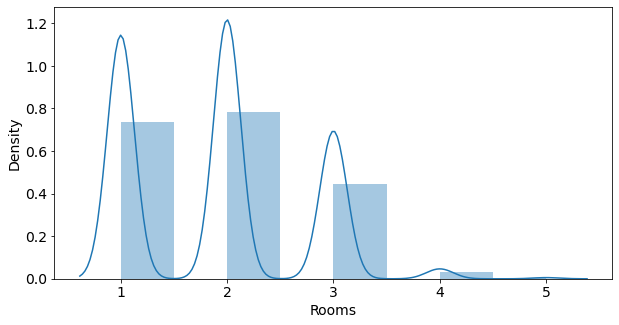

In [23]:
# Посмотри на график распределения признака Rooms после обработки некорректных значений
plt.figure(figsize = (10, 5)) 

sns.distplot(train_data['Rooms'], bins=8)
plt.show()

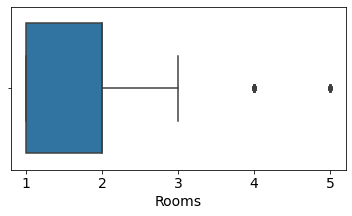

In [24]:
# Посомтрим на знаения, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

## 1.3 Признак KitchenSquare

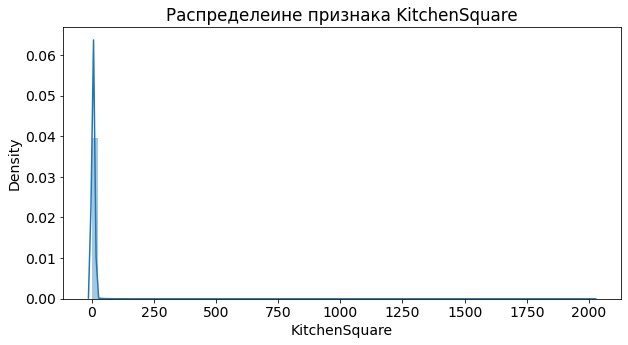

In [25]:
# Распределеине значений признакак KitchenSquare
plt.figure(figsize = (10, 5))

sns.distplot(train_data['KitchenSquare'], bins=80)

plt.title("Распределеине признака KitchenSquare")

plt.show()

In [26]:
#посмотрим на значения признака KitchenSquare
train_data['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

По графику выше и исходя из значениий признака KitchenSquare будем придерживаться следующих гипотез:
- значение признака KitchenSquare должно быть >= 5
- значение признака KitchenSquare должно быть <= квантиля 95%

In [27]:
train_data['KitchenSquare_error'] = 0

In [28]:
train_data.loc[(train_data['KitchenSquare'].isna()) | \
               (train_data['KitchenSquare'] < 5) | \
               (train_data['KitchenSquare'] > train_data['KitchenSquare'].quantile(.975)), 'KitchenSquare_error'] = 1

In [29]:
#заменяем некорректные значения
train_data.loc[(train_data['Square'].isna()) | \
               (train_data['KitchenSquare'] < 5) | \
               (train_data['KitchenSquare'] > train_data['KitchenSquare'].quantile(.975)), 'KitchenSquare'] \
= train_data['KitchenSquare'].median()

### 1.2 Признак Square

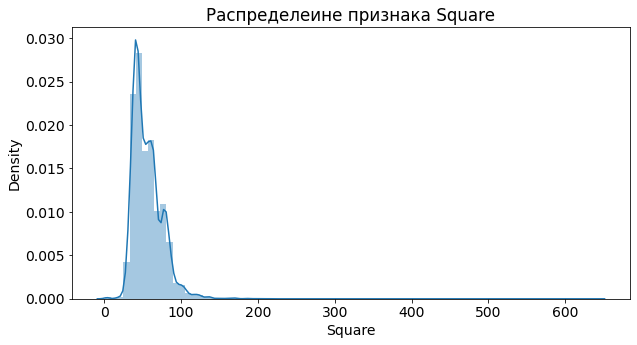

In [30]:
# Распределеине значений признакак Square
plt.figure(figsize = (10, 5))

sns.distplot(train_data['Square'], bins=80)
plt.title("Распределеине признака Square")
plt.show()

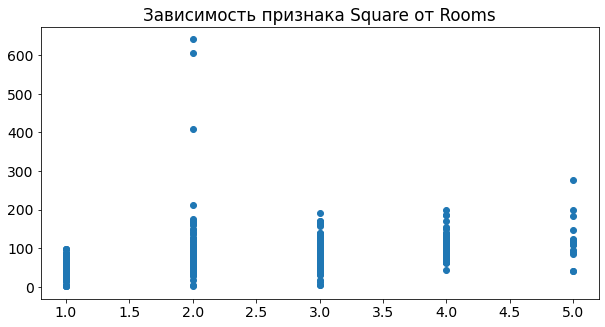

In [31]:
plt.figure(figsize = (10, 5))

plt.scatter(train_data['Rooms'], train_data['Square'])
plt.title("Зависимость признака Square от Rooms")
plt.show()

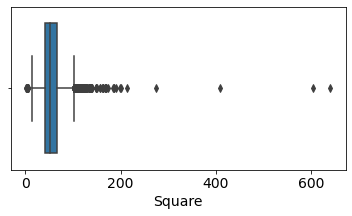

In [32]:
# Посомтрим на знаения, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

Из графиков показанных выше, можно сделать вывод что есть значения признака Square, которые являются выбросами при знаениях признакак Rooms равных 1 и 2. Будем обрабатывать данные выбросы.
Так же будем придерживаться нескольких гипотез:
1. признак Square должен быть > Rooms * min(lifeSquare) + KitchenSquare + 8 (выдвинем гипотезу, что минимальные значения признака LifeSquare = 10. А так же в квартирах есть корридоры, санузлы, балконы, кладовки и прочее - оставим 8 м2 на дополнительне помещения);
2. признак Square (Общая площадь) должен быть больше суммы признаков LifeSquare и KitchenSquare (это условие обработаем после обработки признаков LifeSquare и KitchenSquare, т.к. в этих признаках тоже есть некорректные данные, а так же пропуски);
3. обработаем аномально высокие значения признака, при Square > 250 и цене (Price) ниже величины медианы цены (Price);

Создадим дополнительный признак Square_error, в котором будем помечать: 0 - условие выполняется, 1 - не выполяется).

In [33]:
#Значения признака Square удовлетворяющие 1 условию:
train_data[train_data['Square'] < (train_data['Rooms']*10 + train_data['KitchenSquare'] + 8)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_error,KitchenSquare_error
161,45,1.0,2.954309,5.257278,6.0,3,1.0,1977,0.195781,B,...,23,5212,6,NaN,3,2,B,438005.187500,0,1
242,101,1.0,23.015919,15.739110,6.0,3,5.0,1967,0.225825,A,...,41,6558,7,1548.0,3,2,B,132427.984375,0,1
299,90,1.0,20.924927,10.651456,6.0,7,5.0,1968,0.265089,B,...,37,5288,0,1937.0,3,2,B,128808.085938,0,1
328,27,3.0,4.390331,5.610772,6.0,8,19.0,2016,0.211401,B,...,9,1892,0,NaN,0,1,B,161379.062500,0,1
623,105,1.0,22.072456,16.540035,6.0,4,9.0,1963,0.069660,B,...,31,6119,4,NaN,1,2,B,126778.796875,0,1
768,96,4.0,44.128948,18.212627,10.0,10,13.0,2005,0.041116,B,...,53,14892,4,NaN,1,4,B,201374.609375,0,0
890,112,1.0,20.213127,13.800282,6.0,5,9.0,1974,0.069660,B,...,31,6119,4,NaN,1,2,B,113050.226562,0,1
922,90,3.0,44.418465,21.107737,8.0,10,15.0,1973,0.265089,B,...,37,5288,0,1937.0,3,2,B,214431.000000,0,0
1401,5,1.0,5.129221,5.549458,6.0,1,1.0,1977,0.150818,B,...,16,3433,4,2643.0,4,5,B,369472.406250,0,1
1717,41,1.0,22.691542,13.499648,6.0,7,9.0,1972,0.175055,B,...,36,10055,3,NaN,1,0,B,136682.953125,0,1


In [34]:
#Значения признака Square удовлетворяющие 3 условию:
train_data[(train_data['Square'] > 250) & (train_data['Price'] < train_data['Price'].median())]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_error,KitchenSquare_error
726,9,2.0,604.705994,NaN,6.0,17,18.0,1977,0.161532,B,...,25,5648,1,30.0,2,4,B,187717.250000,0,1
7010,102,2.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,...,26,3889,6,705.0,3,6,B,90470.429688,1,0
9229,30,2.0,641.065186,638.163208,10.0,20,19.0,2019,0.000078,B,...,22,6398,141,1046.0,3,23,B,133529.687500,0,0


In [35]:
# создаем дополнительный признак Square_error, сигнализирующий об ошибке
train_data['Square_error'] = 0

In [36]:
train_data.loc[(train_data['Square'].isna()) | \
               (train_data['Square'] > 250 & (train_data['Price'] < train_data['Price'].median())) | \
               (train_data['Square'] < (train_data['Rooms']*10 + train_data['KitchenSquare'] + 8)) , 'Square_error'] = 1

In [37]:
# функция вычисления медианы площади в зависимости от количества комнат
def median_square_of_room(X):
    median_list = []
    for i in range(1,6):
        median_list.append(X[X['Rooms'] == i].median()['Square'])
    return median_list   

In [38]:
median_square = median_square_of_room(train_data)

In [39]:
# функция замены некорректных значений
#len(train_data['Rooms'].unique())
def square_error_processing(X):
    j = 0
    for i in range(1,6):
        X.loc[(X['Square'].isna() | \
              ((X["Rooms"] == i) & (X['Square'] < (X['Rooms']*10 + X['KitchenSquare'] + 8))) | \
              ((X['Square'] > 250) & (X['Price'] < X['Price'].median()))), 'Square'] = median_square[j]
        j += 1
    return X

In [40]:
train_data = square_error_processing(train_data)

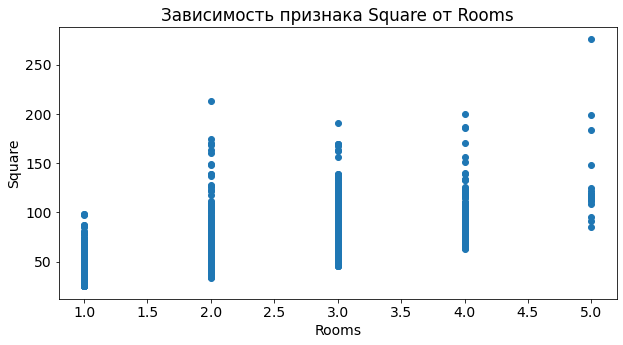

In [41]:
plt.figure(figsize = (10, 5))

plt.scatter(train_data['Rooms'], train_data['Square'])

plt.ylabel('Square')
plt.xlabel('Rooms')

plt.title("Зависимость признака Square от Rooms")
plt.show()

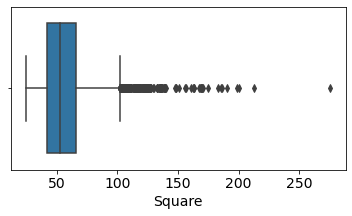

In [42]:
# Посомтрим на знаения, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

## 1.4 Признак LifeSquare

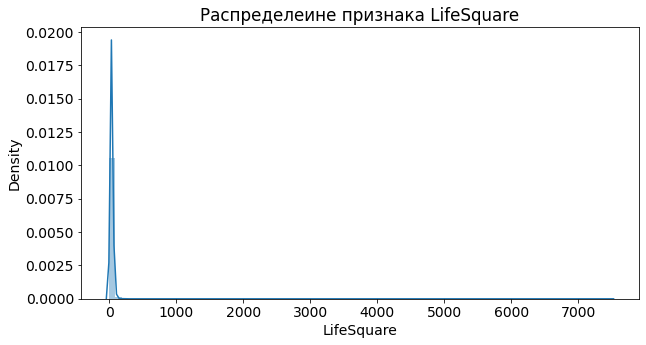

In [43]:
# Распределеине значений признакак LifeSquare
plt.figure(figsize = (10, 5))

sns.distplot(train_data['LifeSquare'], bins=80)
plt.title("Распределеине признака LifeSquare")
plt.show()

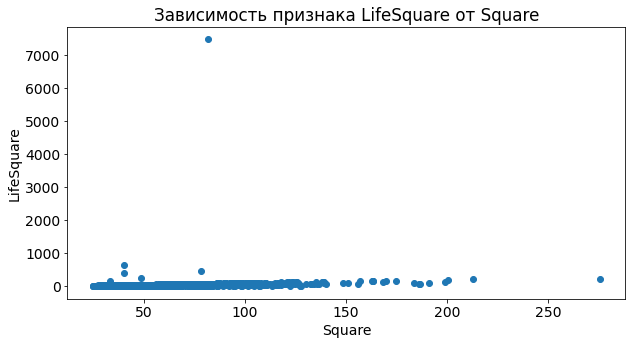

In [44]:
plt.figure(figsize = (10, 5))

plt.scatter(train_data['Square'], train_data['LifeSquare'])

plt.ylabel('LifeSquare')
plt.xlabel('Square')

plt.title("Зависимость признака LifeSquare от Square")
plt.show()

По построенным графикам видны выбросы значений рассматриваемого признака LifeSquare. При анализе будем исходить из следующих гипотез:
- отношение жилой площади к количеству комнат не может быть меньше 10, т.е. площадь одной комнаты не может быть меньше 10 м2
- жилая площадь не может быть больше общей площади за вычетом кухни и дополнительных помещений;

In [45]:
train_data.loc[(train_data['LifeSquare'] > (train_data['Square'] - train_data['KitchenSquare'] - 8)) | \
               (train_data['LifeSquare']/train_data['Rooms'] < 10) | \
               (train_data['LifeSquare'].isna())]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_error,KitchenSquare_error,Square_error
0,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,...,3097,0,NaN,0,0,B,305018.875000,0,0,1
3,1,1.0,40.409908,NaN,6.0,10,22.0,1977,0.007122,B,...,264,0,NaN,0,1,B,168106.000000,0,1,1
6,44,1.0,33.938751,21.772930,9.0,1,12.0,1968,0.232205,B,...,4860,1,80.0,0,3,B,142402.734375,0,0,1
8,1,1.0,46.887894,44.628132,6.0,12,20.0,1977,0.007122,B,...,264,0,NaN,0,1,B,160400.406250,0,1,1
9,6,3.0,79.867477,75.085129,6.0,3,17.0,2014,0.243205,B,...,1564,0,540.0,0,0,B,194756.031250,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,58,2.0,45.118603,33.759010,5.0,8,12.0,1968,0.050756,B,...,5469,1,145.0,0,1,B,227361.500000,0,0,1
9991,6,2.0,62.648777,NaN,6.0,6,17.0,1977,0.243205,B,...,1564,0,540.0,0,0,B,182625.546875,0,1,1
9993,1,3.0,84.486076,88.931511,6.0,4,22.0,2016,0.007122,B,...,264,0,NaN,0,1,B,264213.562500,0,1,1
9998,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,...,8004,3,125.0,3,5,B,171842.406250,0,0,1


In [46]:
# создаем дополнительный признак LifeSquare_error, сигнализирующий об ошибке
train_data['LifeSquare_error'] = 0

In [47]:
#записываем в новый признак информацию 
train_data.loc[(train_data['LifeSquare'].isna()) | \
               (train_data['LifeSquare'] > (train_data['Square'] - train_data['KitchenSquare'] - 8)) | \
               (train_data['LifeSquare']/train_data['Rooms'] < 10), 'LifeSquare_error'] = 1

In [48]:
# Посомтрим на данные с ошибками и пропусками, их почти половина датасета
train_data[train_data['LifeSquare_error']==1]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_error,KitchenSquare_error,Square_error,LifeSquare_error
0,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,...,0,NaN,0,0,B,305018.875000,0,0,1,1
3,1,1.0,40.409908,NaN,6.0,10,22.0,1977,0.007122,B,...,0,NaN,0,1,B,168106.000000,0,1,1,1
6,44,1.0,33.938751,21.772930,9.0,1,12.0,1968,0.232205,B,...,1,80.0,0,3,B,142402.734375,0,0,1,1
8,1,1.0,46.887894,44.628132,6.0,12,20.0,1977,0.007122,B,...,0,NaN,0,1,B,160400.406250,0,1,1,1
9,6,3.0,79.867477,75.085129,6.0,3,17.0,2014,0.243205,B,...,0,540.0,0,0,B,194756.031250,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,58,2.0,45.118603,33.759010,5.0,8,12.0,1968,0.050756,B,...,1,145.0,0,1,B,227361.500000,0,0,1,1
9991,6,2.0,62.648777,NaN,6.0,6,17.0,1977,0.243205,B,...,0,540.0,0,0,B,182625.546875,0,1,1,1
9993,1,3.0,84.486076,88.931511,6.0,4,22.0,2016,0.007122,B,...,0,NaN,0,1,B,264213.562500,0,1,1,1
9998,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,...,3,125.0,3,5,B,171842.406250,0,0,1,1


In [49]:
# Обработаем выбросы, где нарушаются выдвинутые для признака LifeSquare гипотезы
train_data.loc[(train_data['LifeSquare'] > (train_data['Square'] - train_data['KitchenSquare'] - 8)) | \
               (train_data['LifeSquare']/train_data['Rooms'] < 10), 'LifeSquare'] = \
train_data['Square'] - train_data['KitchenSquare'] - 8

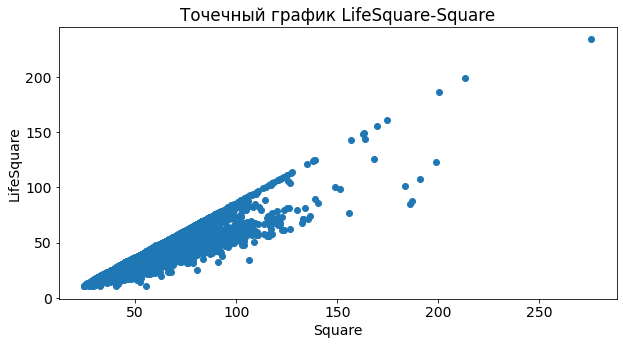

In [50]:
#посомотрим на данные после обработки
plt.figure(figsize = (10, 5))

plt.scatter(train_data['Square'], train_data['LifeSquare'])

plt.ylabel('LifeSquare')
plt.xlabel('Square')

plt.title('Точечный график LifeSquare-Square')
plt.show()

In [51]:
#Проверка
train_data.loc[(train_data['LifeSquare'] > (train_data['Square'] - train_data['KitchenSquare'] - 8)) | \
               (train_data['LifeSquare']/train_data['Rooms'] < 10)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_error,KitchenSquare_error,Square_error,LifeSquare_error


## 1.5 Признаки HouseFloor и Floor

На что будем смотреть в этих признаках:
- значение признаков не могут быть равными 0 и больше 75;
- этаж продаваемой квартиры не может быть больше количества этаже в доме (HouseFloor >= Floor)

In [52]:
train_data['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [53]:
#количество ошибочных строк
(train_data['Floor'] > train_data['HouseFloor']).sum()

1825

In [54]:
train_data['HouseFloor_error'] = 0
train_data['Floor_error'] = 0

In [55]:
train_data.loc[train_data['HouseFloor'] == 0, 'HouseFloor_error'] = 1
train_data.loc[train_data['Floor'] > train_data['HouseFloor'], 'HouseFloor_error'] = 1

In [56]:
train_data.loc[train_data['HouseFloor'] == 0, 'HouseFloor'] = train_data['HouseFloor'].median()

In [57]:
floor_errors_index = train_data.loc[train_data['Floor'] > train_data['HouseFloor']].index
floor_errors_index

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [58]:
train_data.loc[floor_errors_index, 'Floor'] = train_data.loc[floor_errors_index, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [59]:
#проверка:
(train_data['Floor'] > train_data['HouseFloor']).sum()

0

## 1.6 Признак HouseYear

In [60]:
train_data[(train_data['HouseYear'] > datetime.now().year)]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_error,KitchenSquare_error,Square_error,LifeSquare_error,HouseFloor_error,Floor_error
8828,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,...,5,8,B,243028.609375,0,0,1,0,0,0
9163,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,...,3,6,B,254084.531250,0,0,1,0,0,0


In [61]:
#изменим дома из будущего на данную дату:
train_data.loc[(train_data['HouseYear'] > datetime.now().year), 'HouseYear'] = datetime.now().year

# 1.7 Признаки Ecology_1, Ecology_2, Helthcare_2

Для остальных признаков воспользуемся boxplot для выявления выбросов. Заменять все выбросы будем медианой

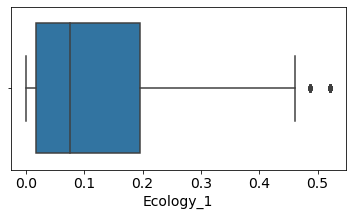

In [62]:
# Посомтрим на знаения признака Ecology_1, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Ecology_1'], whis=1.5)

plt.xlabel('Ecology_1')
plt.show()

In [63]:
#заменяем эти значения
train_data.loc[train_data['Ecology_1']>0.46, 'Ecology_1'] = train_data['Ecology_1'].median()

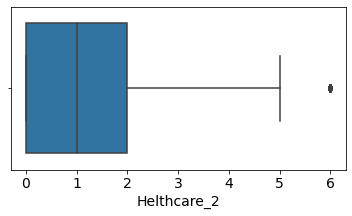

In [64]:
# Посомтрим на знаения признака Helthcare_2, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Helthcare_2'], whis=1.5)

plt.xlabel('Helthcare_2')
plt.show()

In [65]:
#заменяем эти значения
train_data.loc[train_data['Helthcare_2']>5.5, 'Helthcare_2'] = train_data['Helthcare_2'].median()

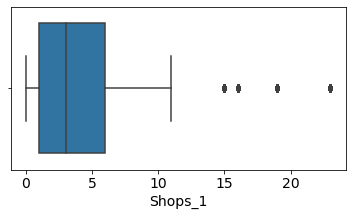

In [66]:
# Посомтрим на знаения признака Shops_1, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Shops_1'], whis=1.5)

plt.xlabel('Shops_1')
plt.show()

In [67]:
#заменяем эти значения
train_data.loc[train_data['Shops_1']>12, 'Shops_1'] = train_data['Shops_1'].median()

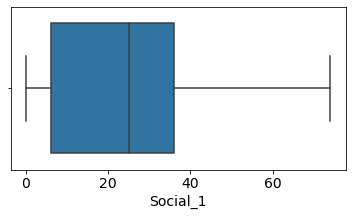

In [68]:
# Посомтрим на знаения признака Social_1, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Social_1'], whis=1.5)

plt.xlabel('Social_1')
plt.show()

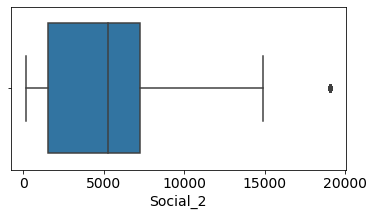

In [69]:
# Посомтрим на знаения признака Social_2, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Social_2'], whis=1.5)

plt.xlabel('Social_2')
plt.show()

In [70]:
#заменяем эти значения
train_data.loc[train_data['Social_2']>17000, 'Social_2'] = train_data['Social_2'].median()

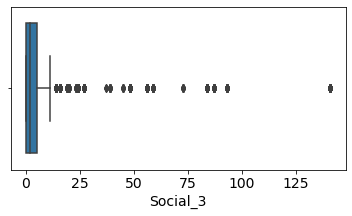

In [71]:
# Посомтрим на знаения признака Social_3, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Social_3'], whis=1.5)

plt.xlabel('Social_3')
plt.show()

In [72]:
#заменяем эти значения
train_data.loc[train_data['Social_3']>12, 'Social_3'] = train_data['Social_3'].median()

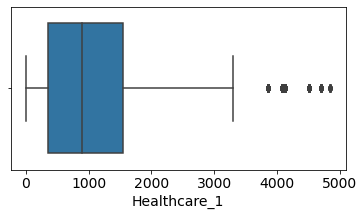

In [73]:
# Посомтрим на знаения признака Social_3, которые могут быть выбросами
plt.figure(figsize=(6, 3))

sns.boxplot(train_data['Healthcare_1'], whis=1.5)

plt.xlabel('Healthcare_1')
plt.show()

In [74]:
#заменяем эти значения
train_data.loc[train_data['Healthcare_1']>3200, 'Healthcare_1'] = train_data['Healthcare_1'].median()

# 2. Обработка пропусков 

In [75]:
# Посмотрим на количество пропусков по всем датасете
train_data.isna().sum()

DistrictId                0
Rooms                     0
Square                    0
LifeSquare             2113
KitchenSquare             0
Floor                     0
HouseFloor                0
HouseYear                 0
Ecology_1                 0
Ecology_2                 0
Ecology_3                 0
Social_1                  0
Social_2                  0
Social_3                  0
Healthcare_1           4798
Helthcare_2               0
Shops_1                   0
Shops_2                   0
Price                     0
Rooms_error               0
KitchenSquare_error       0
Square_error              0
LifeSquare_error          0
HouseFloor_error          0
Floor_error               0
dtype: int64

## 2.1 Признак LifeSquare

In [76]:
#заполнение пропусков в признаке LifeSquare
condition = (train_data['LifeSquare'].isna()) & \
            (~train_data['Square'].isna()) & \
            (~train_data['KitchenSquare'].isna())
        
train_data.loc[condition, 'LifeSquare'] = train_data.loc[condition, 'Square'] \
                                            - train_data.loc[condition, 'KitchenSquare'] - 8

In [77]:
#исправим полученные некорректные значения на медиану для признака Square
def LifeSquare_error_processing(X):
    for rooms in range(1, len(X['Rooms'].unique())):
        X.loc[(X['LifeSquare'] > (X['Square'] - X['KitchenSquare'] - 8)) & (X["Rooms"] == rooms), 'Square'] \
            = X[X['Rooms'] == rooms].median()['Square']   
    return X

In [78]:
train_data = LifeSquare_error_processing(train_data)

In [79]:
#проверка
train_data[(train_data['LifeSquare'] > (train_data['Square'] - train_data['KitchenSquare'] - 8))]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_error,KitchenSquare_error,Square_error,LifeSquare_error,HouseFloor_error,Floor_error


## 2.1 Признак Healthcare_1

Создаем новый признак, где будет отмечено был пропуск в данных или нет

In [80]:
train_data['Healthcare_1_NaN'] = 0

In [81]:
train_data.loc[train_data['Healthcare_1'].isna(), 'Healthcare_1_NaN'] = 1

In [82]:
train_data[train_data['Healthcare_1_NaN'] == 1]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Price,Rooms_error,KitchenSquare_error,Square_error,LifeSquare_error,HouseFloor_error,Floor_error,Healthcare_1_NaN
0,27,3.0,115.027313,97.027313,10.0,4,10.0,2014,0.075424,B,...,0.0,B,305018.875000,0,0,1,1,0,0,1
3,1,1.0,40.409908,26.409908,6.0,10,22.0,1977,0.007122,B,...,1.0,B,168106.000000,0,1,1,1,0,0,1
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,...,6.0,B,343995.093750,0,0,1,0,0,0,1
8,1,1.0,46.887894,32.887894,6.0,12,20.0,1977,0.007122,B,...,1.0,B,160400.406250,0,1,1,1,0,0,1
11,88,2.0,53.975143,34.153584,8.0,2,12.0,1978,0.127376,B,...,9.0,B,253124.000000,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,1,3.0,84.486076,70.486076,6.0,4,22.0,2016,0.007122,B,...,1.0,B,264213.562500,0,1,1,1,0,0,1
9995,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,...,9.0,B,119367.453125,0,0,1,0,0,0,1
9996,27,2.0,64.307686,37.038422,9.0,13,13.0,1977,0.072158,B,...,0.0,A,199715.156250,0,0,1,0,1,0,1
9997,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.075424,B,...,5.0,B,165953.906250,0,0,1,0,0,0,1


будем заполнять пропущенные значения медианой, т.к. она устойчива к выбросам. 

In [83]:
median_Healthcare_1 = train_data['Healthcare_1'].median()
median_Healthcare_1

900.0

In [84]:
train_data['Healthcare_1'].fillna(median_Healthcare_1, inplace=True)

In [85]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.median_square_of_room = None
        #self.square_error_processing = None
        self.median_square = None
        
        #прописать метод уменьшенеия памяти
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        #квантили для расчета площади кухни
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)        
        self.median_square = median_square_of_room(X)
                   
               
        ##############обучить стандартизацию##################
    
    
    
    def transform(self, X):
        """Трансформация данных"""

        ############ тут можно исопльзовать стандартизацию если обучили в fit##############
        
        # Rooms
        
        X['Rooms_error'] = 0
        X.loc[(X['Rooms'].isna()) | \
              (X['Rooms'] == 0) | \
              (X['Rooms'] >= 6) | \
              ((X['Rooms']== 1) & (X['Square']>100)), 'Rooms_error'] = 1
        ##заменяем некорректные значения
        X.loc[(X['Rooms'].isna()) | \
              (X['Rooms'] >= 6) | \
              (X['Rooms'] == 0) | \
              ((X['Rooms']== 1) & (X['Square']>100)), 'Rooms'] = self.medians['Rooms']
        
        
        
        # KitchenSquare
        
        X['KitchenSquare_error'] = 0
        
        X.loc[((X['KitchenSquare'].isna()) | \
              (X['KitchenSquare'] < 5) | \
              (X['KitchenSquare'] > self.kitchen_square_quantile)), 'KitchenSquare_error'] = 1
        ##заменяем некорректные значения
        X.loc[((X['Square'].isna()) | \
              (X['KitchenSquare'] < 5) | \
              (X['KitchenSquare'] > self.kitchen_square_quantile)), 'KitchenSquare'] = X['KitchenSquare'].median()
        
        
        
        # Square
        
        X['Square_error'] = 0
        
        X.loc[((X['Square'].isna()) | (X['Square'] > 250) | \
               (X['Square'] < (X['Rooms']*10 + X['KitchenSquare'] + 8))), 'Square_error'] = 1
        
        ## функция замены некорректных значений Square
        def square_error_processing(X):
            j = 0
            for i in range(1,6):
                X.loc[(X['Square'].isna() | \
                        ((X["Rooms"] == i) & (X['Square'] < (X['Rooms']*10 + X['KitchenSquare'] + 8))) | \
                        (X['Square'] > 250)), 'Square'] = median_square[j]
                j += 1

            return X
   
        X = square_error_processing(X)
            
            
        
        # LifeSquare
        
        X['LifeSquare_error'] = 0
 
        X.loc[(X['LifeSquare'].isna()) | \
              (X['LifeSquare'] > (X['Square'] - X['KitchenSquare'] - 8)) | \
              (X['LifeSquare']/X['Rooms'] < 10), 'LifeSquare_error'] = 1
        
        ##заменяем некорректные значения
        X.loc[(X['LifeSquare'] > (X['Square'] - X['KitchenSquare'] - 8)) | \
              (X['LifeSquare']/X['Rooms'] < 10), 'LifeSquare'] = X['Square'] - X['KitchenSquare'] - 8
        
        ##заполнение пропусков в признаке LifeSquare
        condition = (X['LifeSquare'].isna()) & (~X['Square'].isna()) & (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 8
        

        
        # HouseFloor, Floor 
        
        X['HouseFloor_error'] = 0
        X['Floor_error'] = 0
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_error'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_error'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = X['HouseFloor'].median()
        
        floor_errors_index = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_errors_index, 'Floor'] = X.loc[floor_errors_index, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        
        X.loc[(X['HouseYear'] > datetime.now().year), 'HouseYear'] = datetime.now().year
        
        X.fillna(self.medians, inplace=True)

        
        #Healthcare_1
        
        X['Healthcare_1_NaN'] = 0
        X.loc[(X['Healthcare_1'].isna() | (X['Healthcare_1']>3200)), 'Healthcare_1_NaN'] = 1
        
        X['Healthcare_1'].fillna(self.medians['Healthcare_1'], inplace=True)
        X.loc[X['Healthcare_1']>3200, 'Healthcare_1'] = self.medians['Healthcare_1']

        #Social_3
        X.loc[X['Social_3']>12, 'Social_3'] = self.medians['Social_3']

        #Social_2
        X.loc[X['Social_2']>17000, 'Social_2'] = self.medians['Social_2']

        #Shops_1
        X.loc[X['Shops_1']>12, 'Shops_1'] = self.medians['Shops_1']

        #Helthcare_2
        X.loc[X['Helthcare_2']>5.5, 'Helthcare_2'] = self.medians['Helthcare_2']

        #Ecology_1
        X.loc[X['Ecology_1']>0.46, 'Ecology_1'] = self.medians['Ecology_1']
        
        
        X.fillna(self.medians, inplace=True)
               
        
        return X
      
# функция вычисления медианы площади в зависимости от количества комнат
    def median_square_of_room(X):
        median_list = []
        for i in range(1,6):
            median_list.append(X[X['Rooms'] == i].median()['Square'])

        return median_list        

    


# 3. Построение новых признаков

## 3.1  Ecology_2, Ecology_3, Shops_2

In [86]:
train_data['DistrictId'] = train_data['DistrictId'].astype(str)

In [87]:
train_data.select_dtypes(include='category').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [88]:
binary_to_numbers = {'A': 0, 'B': 1}

train_data['Ecology_2'] = train_data['Ecology_2'].replace(binary_to_numbers)
train_data['Ecology_3'] = train_data['Ecology_3'].replace(binary_to_numbers)
train_data['Shops_2'] = train_data['Shops_2'].replace(binary_to_numbers)

## 3.2 DistrictSize

In [89]:
#создадим новый признак - DistrictSize, который будет основан на количестве домов в каждом районе
district_size = train_data['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [90]:
#присоединим наш новый признак к датафрейму
train_data = train_data.merge(district_size, on='DistrictId', how='left')
train_data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_2,Price,Rooms_error,KitchenSquare_error,Square_error,LifeSquare_error,HouseFloor_error,Floor_error,Healthcare_1_NaN,DistrictSize
0,27,3.0,115.027313,97.027313,10.0,4,10.0,2014,0.075424,1,...,1,305018.875000,0,0,1,1,0,0,1,851
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,...,1,177734.546875,0,0,1,0,0,0,0,78
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,1,282078.718750,0,0,1,0,0,0,0,652
3,1,1.0,40.409908,26.409908,6.0,10,22.0,1977,0.007122,1,...,1,168106.000000,0,1,1,1,0,0,1,652
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,1,343995.093750,0,0,1,0,0,0,1,89


## 3.3 IsDistrictLarge

In [91]:
#будем считать район большим, если в нем продается на данный момент более 150 квартир
(train_data['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [92]:
#создаем новый признак IsDistrictLarge на основе предыдущего условия
train_data['IsDistrictLarge'] = (train_data['DistrictSize'] > 100).astype(int)

In [93]:
train_data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Price,Rooms_error,KitchenSquare_error,Square_error,LifeSquare_error,HouseFloor_error,Floor_error,Healthcare_1_NaN,DistrictSize,IsDistrictLarge
0,27,3.0,115.027313,97.027313,10.0,4,10.0,2014,0.075424,1,...,305018.875000,0,0,1,1,0,0,1,851,1
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,...,177734.546875,0,0,1,0,0,0,0,78,0
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,282078.718750,0,0,1,0,0,0,0,652,1
3,1,1.0,40.409908,26.409908,6.0,10,22.0,1977,0.007122,1,...,168106.000000,0,1,1,1,0,0,1,652,1
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,343995.093750,0,0,1,0,0,0,1,89,0


## 3.4 Med_price_by_district

In [94]:
med_price_by_district = train_data.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142486.171875
1,0,2.0,176765.906250
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [95]:
train_data = train_data.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Rooms_error,KitchenSquare_error,Square_error,LifeSquare_error,HouseFloor_error,Floor_error,Healthcare_1_NaN,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,27,3.0,115.027313,97.027313,10.0,4,10.0,2014,0.075424,1,...,0,0,1,1,0,0,1,851,1,213530.781250
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,...,0,0,1,0,0,0,0,78,0,146032.828125
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,0,0,1,0,0,0,0,652,1,244005.281250
3,1,1.0,40.409908,26.409908,6.0,10,22.0,1977,0.007122,1,...,0,1,1,1,0,0,1,652,1,146735.671875
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,0,0,1,0,0,0,1,89,0,201584.437500


## 3.5 floor_to_cat, year_to_cat, square_to_cats

Создаем новые категориальные признаки из вещественных

In [96]:
# из этажа квартиры делаем категориальный признак
def floor_to_cat(X):
    bins = [0, 3, 5, 9, 16, 25, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

# из года постройки дома делаем категориальный признак
def year_to_cat(X):
    bins = [0, 1941, 1945, 1960, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

# из площади квартиры делаем категориальный признак
def square_to_cat(X):
    bins = [0, 40, 60, 80, 120, X['Square'].max()]
    X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
    
    X['square_cat'].fillna(-1, inplace=True)
    return X

In [97]:
#добавим новые категориальные признаки в датасет
train_data = floor_to_cat(train_data)
train_data = year_to_cat(train_data)
train_data = square_to_cat(train_data)
train_data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,LifeSquare_error,HouseFloor_error,Floor_error,Healthcare_1_NaN,DistrictSize,IsDistrictLarge,MedPriceByDistrict,floor_cat,year_cat,square_cat
0,27,3.0,115.027313,97.027313,10.0,4,10.0,2014,0.075424,1,...,1,0,0,1,851,1,213530.781250,1,6,3
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,...,0,0,0,0,78,0,146032.828125,2,3,0
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,0,0,0,0,652,1,244005.281250,0,4,2
3,1,1.0,40.409908,26.409908,6.0,10,22.0,1977,0.007122,1,...,1,0,0,1,652,1,146735.671875,3,3,1
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,0,0,0,1,89,0,201584.437500,3,3,2


## 3.6 med_price_by_floor_year

In [98]:
med_price_by_floor_year = train_data.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,0,0,348257.56250
1,0,1,329090.75000
2,0,2,429458.37500
3,0,3,274992.46875
4,1,0,467230.53125


In [99]:
train_data = train_data.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,HouseFloor_error,Floor_error,Healthcare_1_NaN,DistrictSize,IsDistrictLarge,MedPriceByDistrict,floor_cat,year_cat,square_cat,MedPriceByFloorYear
0,27,3.0,115.027313,97.027313,10.0,4,10.0,2014,0.075424,1,...,0,0,1,851,1,213530.781250,1,6,3,167082.62500
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,...,0,0,0,78,0,146032.828125,2,3,0,189646.75000
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,0,0,0,652,1,244005.281250,0,4,2,208441.37500
3,1,1.0,40.409908,26.409908,6.0,10,22.0,1977,0.007122,1,...,0,0,1,652,1,146735.671875,3,3,1,182695.03125
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,0,0,1,89,0,201584.437500,3,3,2,182695.03125


## 3.7 med_price_by_square_cat

In [100]:
med_price_by_square_cat = train_data.groupby('square_cat', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})
med_price_by_square_cat.head()

,square_cat,MedPriceBySquare
0,0,158881.671875
1,1,183583.406250
2,2,229102.796875
3,3,297385.937500
4,4,282877.343750


In [101]:
train_data = train_data.merge(med_price_by_square_cat, on='square_cat', how='left')
train_data.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Floor_error,Healthcare_1_NaN,DistrictSize,IsDistrictLarge,MedPriceByDistrict,floor_cat,year_cat,square_cat,MedPriceByFloorYear,MedPriceBySquare
0,27,3.0,115.027313,97.027313,10.0,4,10.0,2014,0.075424,1,...,0,1,851,1,213530.781250,1,6,3,167082.62500,297385.937500
1,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,1,...,0,0,78,0,146032.828125,2,3,0,189646.75000,158881.671875
2,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,1,...,0,0,652,1,244005.281250,0,4,2,208441.37500,229102.796875
3,1,1.0,40.409908,26.409908,6.0,10,22.0,1977,0.007122,1,...,0,1,652,1,146735.671875,3,3,1,182695.03125,183583.406250
4,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,1,...,0,1,89,0,201584.437500,3,3,2,182695.03125,229102.796875


In [102]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        self.med_price_by_square_cat = None
        
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year, square
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            self.square_max = df['Square'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            df = self.square_to_cat(df)
            
            
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
            self.med_price_by_square_cat = df.groupby('square_cat', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySquare'})
            self.med_price_by_square_cat_median = self.med_price_by_square_cat['MedPriceBySquare'].median()

            
            
        
    def transform(self, X):
        
        # Binary features
        
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.square_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        if self.med_price_by_square_cat is not None:
            X = X.merge(med_price_by_square_cat, on='square_cat', how='left')
            X.fillna(self.med_price_by_square_cat_median, inplace=True)

        
        return X
    
    
        # из этажа квартиры делаем категориальный признак
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 16, 25, X['Floor'].max()]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
        X['floor_cat'].fillna(-1, inplace=True)
        
        return X

    # из года постройки дома делаем категориальный признак
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1960, 1980, 2000, 2010, X['HouseYear'].max()]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
        X['year_cat'].fillna(-1, inplace=True)
        
        return X

    # из площади квартиры делаем категориальный признак
    def square_to_cat(self, X):
        bins = [0, 40, 60, 80, 120, X['Square'].max()]
        X['square_cat'] = pd.cut(X['Square'], bins=bins, labels=False)
        X['square_cat'].fillna(-1, inplace=True)
        
        return X

## 4. Отбор признаков

In [103]:
train_data.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Rooms_error',
 'KitchenSquare_error',
 'Square_error',
 'LifeSquare_error',
 'HouseFloor_error',
 'Floor_error',
 'Healthcare_1_NaN',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'floor_cat',
 'year_cat',
 'square_cat',
 'MedPriceByFloorYear',
 'MedPriceBySquare']

In [104]:
#обучать будем на слудующих признаках:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['KitchenSquare_error', 'LifeSquare_error', 'HouseFloor_error',
                     'DistrictSize', 'IsDistrictLarge', 'MedPriceByFloorYear', 'MedPriceBySquare']
target_name = 'Price'

## 5. Разбиение на train и test

In [105]:
train_data = pd.read_csv(TRAIN_DATASET_PATH)
test_data = pd.read_csv(TEST_DATASET_PATH)

X = train_data.drop(columns=target_name)
y = train_data[target_name]

In [106]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [107]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_data = preprocessor.transform(test_data)

X_train.shape, X_valid.shape, test_data.shape

((8000, 26), (2000, 26), (5000, 26))

In [108]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_data = features_gen.transform(test_data)

X_train.shape, X_valid.shape, test_data.shape

((8000, 35), (2000, 35), (5000, 35))

In [109]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_data = test_data[feature_names + new_feature_names]

In [110]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_data.isna().sum().sum()

(0, 0, 0)

## 6. Обучение различных моделей моделей

### 6.1 LinearRegression

Train R2:	0.604
Test R2:	0.63


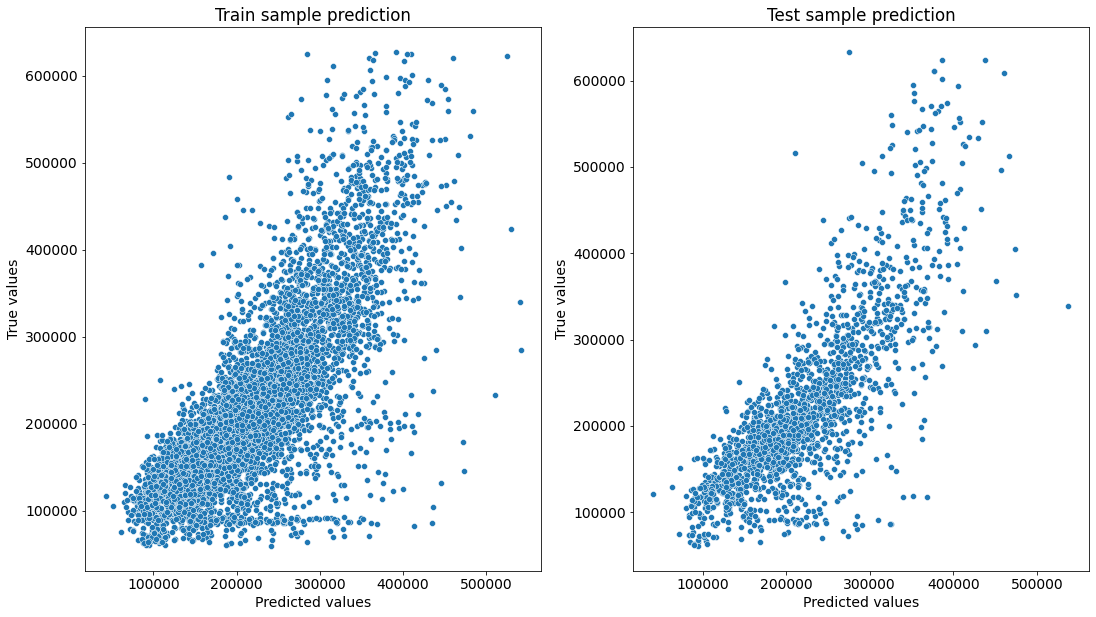

In [111]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_preds = lr_model.predict(X_train)
y_test_preds = lr_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### 6.2 RandomForest

In [112]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=50, # глубина дерева  
                                 min_samples_leaf=25, # минимальное кол-во наблюдений в листе дерева
                                 max_features='log2',
                                 random_state=42, 
                                 n_estimators=500  # кол-во деревьев
                                 )
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, max_features='log2', min_samples_leaf=25,
                      n_estimators=500, random_state=42)

Train R2:	0.718
Test R2:	0.705


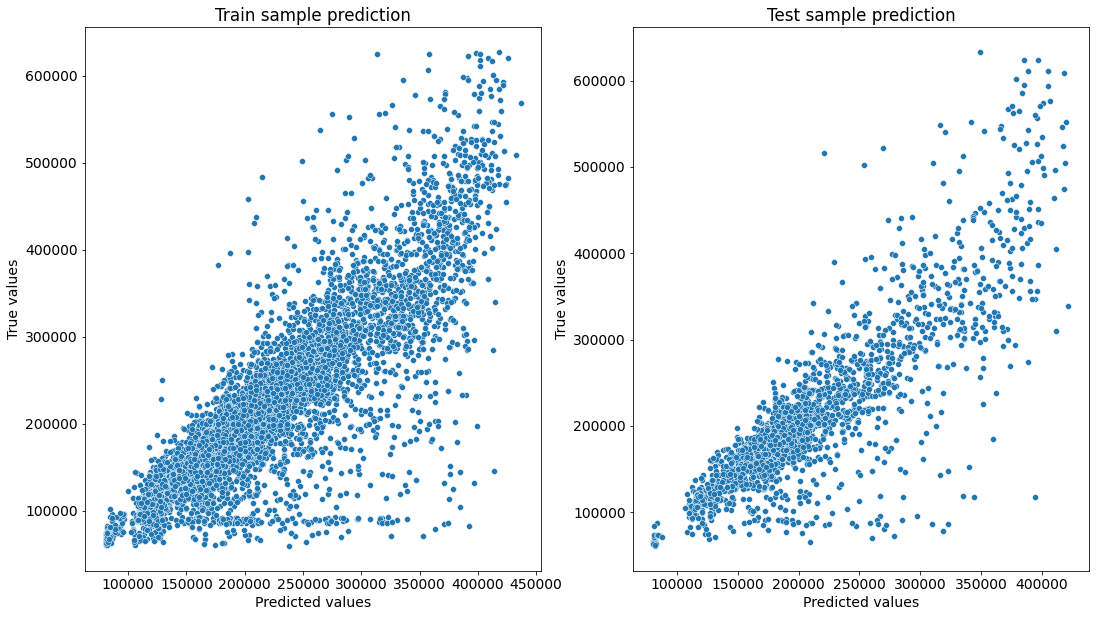

In [113]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### 6.3 GradientBoosting

In [114]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=60,
                                     random_state=42,  
                                     n_estimators=800, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)

gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=7, max_features='sqrt', min_samples_leaf=60,
                          n_estimators=800, random_state=42)

Train R2:	0.818
Test R2:	0.773


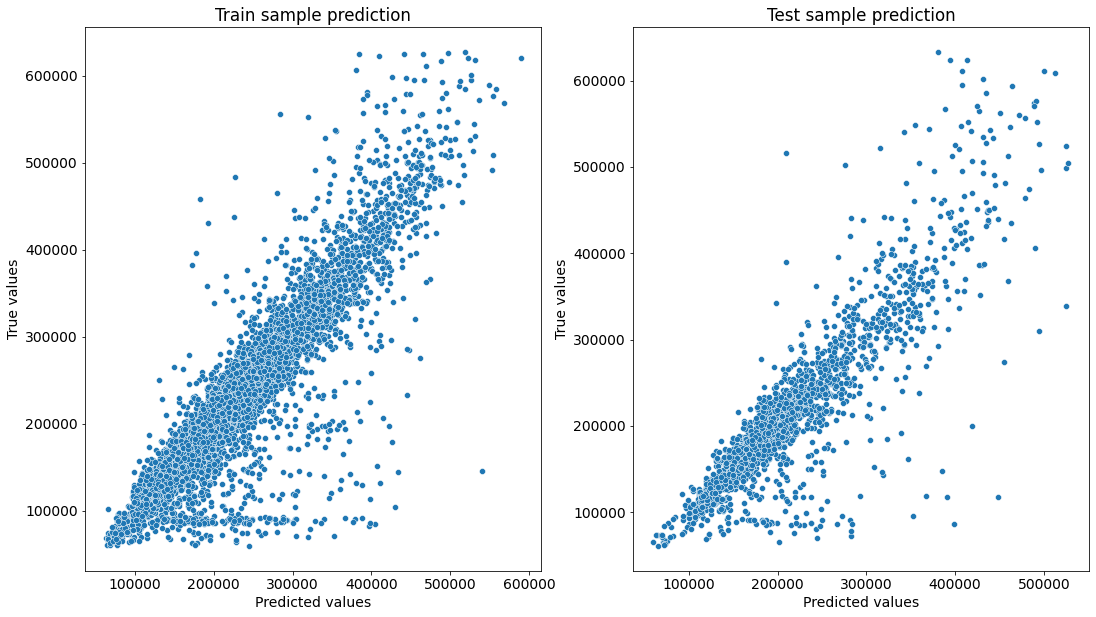

In [115]:
#посомтрим на сходиость результатов
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

#y_train_preds = rf_model.predict(X_train)
#y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## 6.4 Кросс-валидация

In [116]:
#для линейной модели
cv_score = cross_val_score(lr_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.60042276, 0.5793972 , 0.59102902, 0.61505683, 0.6159113 ])

In [117]:
cv_score.mean()

0.6003634218474856

In [118]:
#для случайного леса
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.67303664, 0.65876492, 0.66789368, 0.69119559, 0.68074386])

In [119]:
cv_score.mean()

0.6743269368018213

In [120]:
#для градиентного бустинга
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))
cv_score

array([0.73020432, 0.72024754, 0.7322857 , 0.76797512, 0.75705442])

In [121]:
cv_score.mean()

0.7415534197713274

# 6. Важность признаков

In [122]:
#для  модели градиентного бустинга
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.145552
22,MedPriceBySquare,0.121816
0,Rooms,0.111406
2,LifeSquare,0.094226
19,DistrictSize,0.081986
10,Social_1,0.077017
20,IsDistrictLarge,0.063342
21,MedPriceByFloorYear,0.051017
12,Social_3,0.045023
11,Social_2,0.044730


# 7. Комбо различных моделей

In [123]:
from sklearn.ensemble import StackingRegressor, VotingRegressor, BaggingRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(criterion='mse',
                                 max_depth=50,  
                                 min_samples_leaf=25, 
                                 max_features='log2',
                                 random_state=42, 
                                 n_estimators=500  
                                 )
gb = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=60,
                                     random_state=42,  
                                     n_estimators=800, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)
gb2 = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=60,
                                     random_state=42,  
                                     n_estimators=800, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)
stack = StackingRegressor([('rf', rf), ('gb', gb)], final_estimator=gb2)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('rf',
                               RandomForestRegressor(max_depth=50,
                                                     max_features='log2',
                                                     min_samples_leaf=25,
                                                     n_estimators=500,
                                                     random_state=42)),
                              ('gb',
                               GradientBoostingRegressor(criterion='mse',
                                                         learning_rate=0.025,
                                                         loss='huber',
                                                         max_depth=7,
                                                         max_features='sqrt',
                                                         min_samples_leaf=60,
                                                         n_estimators=800,
                                            

Train R2:	0.815
Test R2:	0.771


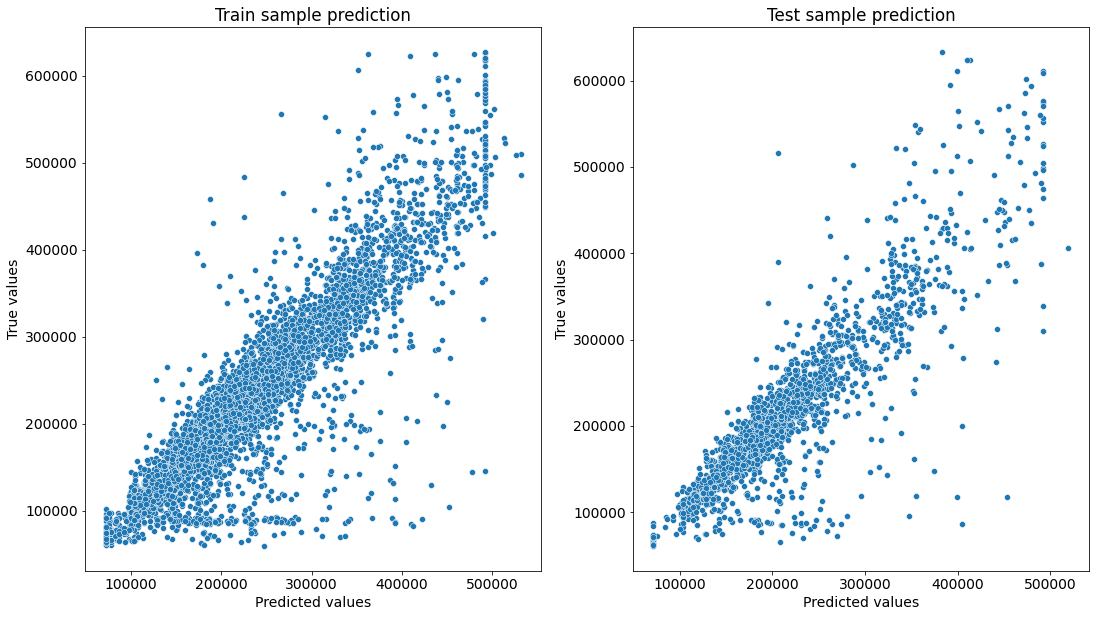

In [124]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

# 7. Прогнозирование на тестовом датасете

In [125]:
test_data.shape

(5000, 23)

In [126]:
test_data.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Helthcare_2,Shops_1,Shops_2,KitchenSquare_error,LifeSquare_error,HouseFloor_error,DistrictSize,IsDistrictLarge,MedPriceByFloorYear,MedPriceBySquare
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1.0,1.0,1,0,0,0,83.0,0,183900.029135,158881.671875
1,1.0,42.493907,24.493907,10.0,7,17.0,2017,0.072158,1,1,...,0.0,0.0,0,0,1,0,193.0,1,169595.381433,183583.406250
2,2.0,59.463678,42.463678,9.0,19,19.0,1977,0.211401,1,1,...,0.0,1.0,1,0,1,0,685.0,1,173068.576048,183583.406250
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0.0,0.0,1,0,0,0,452.0,1,178038.437391,183583.406250
4,1.0,53.837056,39.837056,6.0,8,17.0,1977,0.309479,1,1,...,0.0,6.0,1,1,1,0,96.0,0,189464.781345,183583.406250


In [127]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [128]:
predictions = stack.predict(test_data)
predictions

array([173009.33952845, 122142.44090278, 143357.82824146, ...,
       151090.30178996, 192635.12606337, 252055.41047315])

In [129]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,173009.339528
1,5925,122142.440903
2,960,143357.828241
3,3848,113073.466318
4,746,177752.071404


In [130]:
submit.to_csv('kos_teml.csv', index=False)